# Gradient Boosting Machine for Heating Load

In [4]:
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import validation_curve


%matplotlib inline 

# Preprocessing

In [2]:
dataframe_all=pd.read_csv('ENB2012.csv')
dataframe_all.Y1 = dataframe_all.Y1.round()
dataframe_all.Y2 = dataframe_all.Y2.round()

x = dataframe_all.iloc[:,:-2].values
#Extracting the outputs for HeatLoad and ColdLoad.
y1_HL=dataframe_all.iloc[:,-2].values.ravel()
y2_CL=dataframe_all.iloc[:,-1].values.ravel()
print("Shape x:  {}     Shape y1_HL: {}  Shape y2_CL: {}".format(x.shape, y1_HL.shape,y2_CL.shape)) 

Shape x:  (768, 8)     Shape y1_HL: (768,)  Shape y2_CL: (768,)


In [6]:
# 25% for Test Size
X_train, X_test, y_train, y_test = train_test_split(x, y1_HL,random_state=0)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Grid Search

In [3]:
#Find M Boosting Iterations
param_grid = [{'max_depth':[2,3,4,5],'n_estimators':[40,50,100,500]}]
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
[{'max_depth': [2, 3, 4, 5], 'n_estimators': [40, 50, 100, 500]}]


In [65]:
grid_search = GridSearchCV(GradientBoostingClassifier(
                            #max_depth=3,
                            #learning_rate=0.1,
                            #subsample =0.9,                                            
                            random_state =0
                            ) 
                               , param_grid, cv=kfold, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))


Best parameters: {'max_depth': 4, 'n_estimators': 50}
Best cross-validation score: -0.98
Test set score: -0.64


In [66]:
results = pd.DataFrame(grid_search.cv_results_)
scores = grid_search.cv_results_['mean_test_score'].reshape(len(param_grid[0]['n_estimators']), len(param_grid[0]['max_depth']))


## Hyperparameter Heatmap

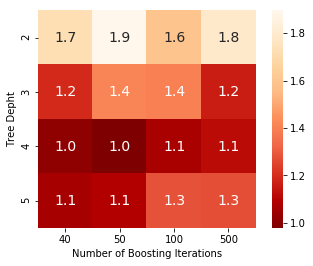

In [69]:
import seaborn as sns
ax = sns.heatmap(
    np.abs(scores),
    cmap="OrRd_r",
    cbar=True,
    annot=True,
    square=True,
    fmt='.1f',
    yticklabels=(param_grid[0]['max_depth']),
    xticklabels=(param_grid[0]['n_estimators']),
    annot_kws={'size': 14})
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('Tree Depht')
plt.savefig("./plots/GBM/Y1/heatmap_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()
sns.reset_orig()

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


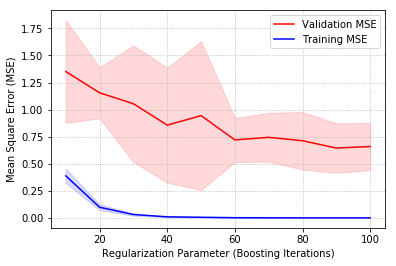

In [8]:
param_range = [10,20,30,40,50,60,70,80,90,100]
train_scores, test_scores = validation_curve(
                                                estimator=GradientBoostingClassifier(
                                                                                        max_depth=4,
                                                                                        learning_rate=0.1,                          
                                                                                        random_state =0
                                                                                        ),
                                                X=X_train,
                                                y=y_train,
                                                param_name="n_estimators",
                                                param_range=param_range,
                                                scoring='neg_mean_squared_error',
                                                cv=5)
train_scores = np.abs(train_scores)
test_scores = np.abs(test_scores)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, test_mean,
    color='red',    
    label='Validation MSE')
plt.fill_between(param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='red')
plt.plot(param_range, train_mean,
    color='blue',   
    label='Training MSE')
plt.fill_between(param_range, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.legend(loc=0, fontsize =10)
plt.xlabel("Regularization Parameter (Boosting Iterations)")
plt.ylabel('Mean Square Error (MSE)')
#plt.xlim([1e-5, 10])
#plt.ylim([0, 20])
plt.grid(linestyle='dotted')
plt.savefig("./plots/GBM/Y1/validation_curve_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()

# Early Stopping

In [56]:
val_error=[]
train_error =[] 
bst_n_estimators_list=[]

for i in range (1,11):
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split( X_train, y_train)

    gbrt = GradientBoostingClassifier(
                                        n_estimators=200,
                                        max_depth=4,
                                        learning_rate=0.1,
                                    )

    gbrt.fit(X_train_val, y_train_val)
    errors = [mean_squared_error(y_test_val, y_pred)
        for y_pred in gbrt.staged_predict(X_test_val)]
    val_error.append(errors)

    errors_train = [mean_squared_error(y_train_val, y_pred_train)
        for y_pred_train in gbrt.staged_predict(X_train_val)]
    
    train_error.append(errors_train)
    bst_n_estimators = np.argmin(errors)
    bst_n_estimators_list.append(bst_n_estimators)



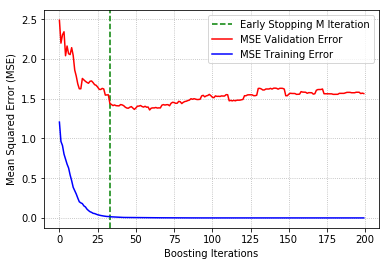

In [58]:
plt.axvline(np.round(np.mean(bst_n_estimators_list, axis=0)), color='g', linestyle='--',label='Early Stopping M Iteration')
plt.xlabel('Boosting Iterations')
plt.ylabel('Mean Squared Error (MSE)')
#Axes.vlines(x, ymin, ymax, colors='k', linestyles='solid', label='', *, data=None, **kwargs)
plt.plot(np.mean(val_error, axis=0), color='r',label='MSE Validation Error')
plt.plot(np.mean(train_error, axis=0), color='b',label='MSE Training Error')
plt.grid(linestyle='dotted')
plt.legend(loc=0, fontsize =10)
plt.savefig("./plots/GBM/Y1/error_vs_iterations_Y1HL.png", dpi=300, bbox_inches='tight') # save as png

plt.show()

# Final Model

In [72]:
MSE_test_list =[]
MSE_train_list =[]
MSE_val_list=[]

#Run for 10 times.
for i in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(x, y1_HL)    
    kfold = KFold(n_splits=5, shuffle=True)
    
    gbc =GradientBoostingClassifier(n_estimators=50, max_depth =3 )
    scores = cross_validate(gbc, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold, return_train_score=True)
    
    MSE_val_list.append(np.mean(np.abs(scores['test_score'])))
    MSE_train_list.append(np.mean(np.abs(scores['train_score'])))
    
    gbc.fit(X_train, y_train)
    y_pred_test = gbc.predict(X_test)

    MSE_test=mean_squared_error(y_test, y_pred_test)
    MSE_test_list.append(MSE_test)

    
print("Test Set MSE:               {:.2f}±{:.2f}".format(np.mean(MSE_test_list),np.std(MSE_test_list)))
print("Train Set MSE:              {:.2f}±{:.2f}".format(np.mean(MSE_train_list),np.std(MSE_train_list)))
print("Validation Set MSE:         {:.2f}±{:.2f}".format(np.mean(MSE_val_list),np.std(MSE_val_list)))


Test Set MSE:               0.80±0.50
Train Set MSE:              0.04±0.01
Validation Set MSE:         0.92±0.21


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Feature Importance

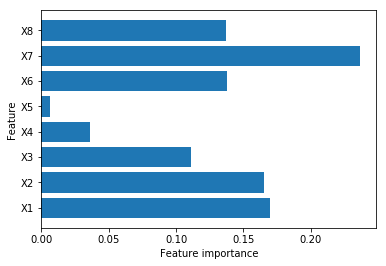

In [63]:
feature_names=['X1','X2','X3','X4','X5','X6','X7','X8']

def plot_feature_importances_cancer(model):
    n_features = x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(gbc)
plt.savefig("./plots/GBM/Y1/feature_importances_Y1HL.png", dpi=300, bbox_inches='tight') # save as png



# Metrics

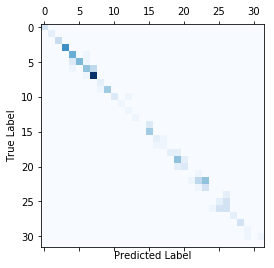

In [61]:
from sklearn.metrics import confusion_matrix
conf_mx=confusion_matrix(y_test, y_pred_test)
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel('True Label')
plt.savefig("./plots/GBM/Y1/confusion_matrix_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()

In [62]:
from sklearn.metrics import classification_report
target_names = np.unique(y_test).astype(int).astype(np.str)
print(classification_report(y_test, y_pred_test, target_names=None))

             precision    recall  f1-score   support

        6.0       1.00      1.00      1.00         4
        7.0       1.00      1.00      1.00         2
       10.0       1.00      1.00      1.00         5
       11.0       1.00      1.00      1.00        14
       12.0       0.73      0.92      0.81        12
       13.0       1.00      0.71      0.83        14
       14.0       0.75      0.56      0.64        16
       15.0       0.79      0.96      0.86        23
       16.0       0.67      1.00      0.80         2
       17.0       1.00      0.89      0.94         9
       18.0       1.00      0.75      0.86         4
       19.0       1.00      1.00      1.00         1
       20.0       0.50      1.00      0.67         1
       21.0       1.00      1.00      1.00         1
       23.0       0.00      0.00      0.00         3
       24.0       0.73      1.00      0.84         8
       25.0       0.67      0.67      0.67         3
       26.0       0.50      0.50      0.50   

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
